In [1]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation, QFT

import sys
sys.path.append('../../funcs')
from spectral1d import QuantumReflection
from piecewise_bivarpoly import BivarPolyLimit

import numpy as np
from numpy.polynomial import polynomial as poly
import matplotlib.pyplot as plt

import h5py

In [2]:
# boundary satisfying function snd its second derivative
def g(x,y):
    return 0.5 + (1.5 * x**2) + (2.5 * y ** 2)

def d2g(x,y):
    return (9 * x + 15 * y)

def forcing(x,y):
    return (((17*np.pi*np.pi * np.sin(x*np.pi) * np.sin(4*y*np.pi)) + (13*np.pi*np.pi * np.sin(2*x*np.pi) * np.sin(3*y*np.pi)))) -  (9 * x + 15 * y)

@np.vectorize
def freqs_inv(k):
    """Return the square of the relabeled frequencies."""
    return k**2

def freqs_inv_coeffs(N, k0_left, k1_lower, deg):
    """Fit a polynomial of degree deg to 1/k^2 on a domain of [0, N-1]x[0, N-1]"""
    """Return the value of the polynomial coefficients"""
    # domain length
    k_domain_len = N-1

    # interpolation points in 1D
    intp_pts_1d_k0 = np.linspace(k0_left, k_domain_len, deg+1) # change to the starting point
    intp_pts_1d_k1 = np.linspace(k1_lower, k_domain_len, deg+1)

    # interpolation points in 2D and the Vandermonde matrix
    kx_intp, ky_intp = np.meshgrid(intp_pts_1d_k0, intp_pts_1d_k1)
    van_mat = poly.polyvander2d(kx_intp.flatten(), ky_intp.flatten(), deg=(deg, deg))

    # compute the inverse square of the frequencies
    k_sqr = 1/(freqs_inv(kx_intp) + freqs_inv(ky_intp))

    # conditioning of the vandermonde matrix
    scale = np.abs(van_mat).sum(axis=0)
    van_mat /= scale

    poly_coeffs, resids, rank, s = np.linalg.lstsq(van_mat, k_sqr.flatten(), rcond=None)
    poly_coeffs = (poly_coeffs.T/scale).T
    
    return poly_coeffs.reshape([deg+1, deg+1])


/var/folders/tn/bpv7203512s5w_qmpd5848z80000gn/T/ipykernel_16053/4183127436.py:53: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=nq_x+nb_x,inverse=False).to_gate()


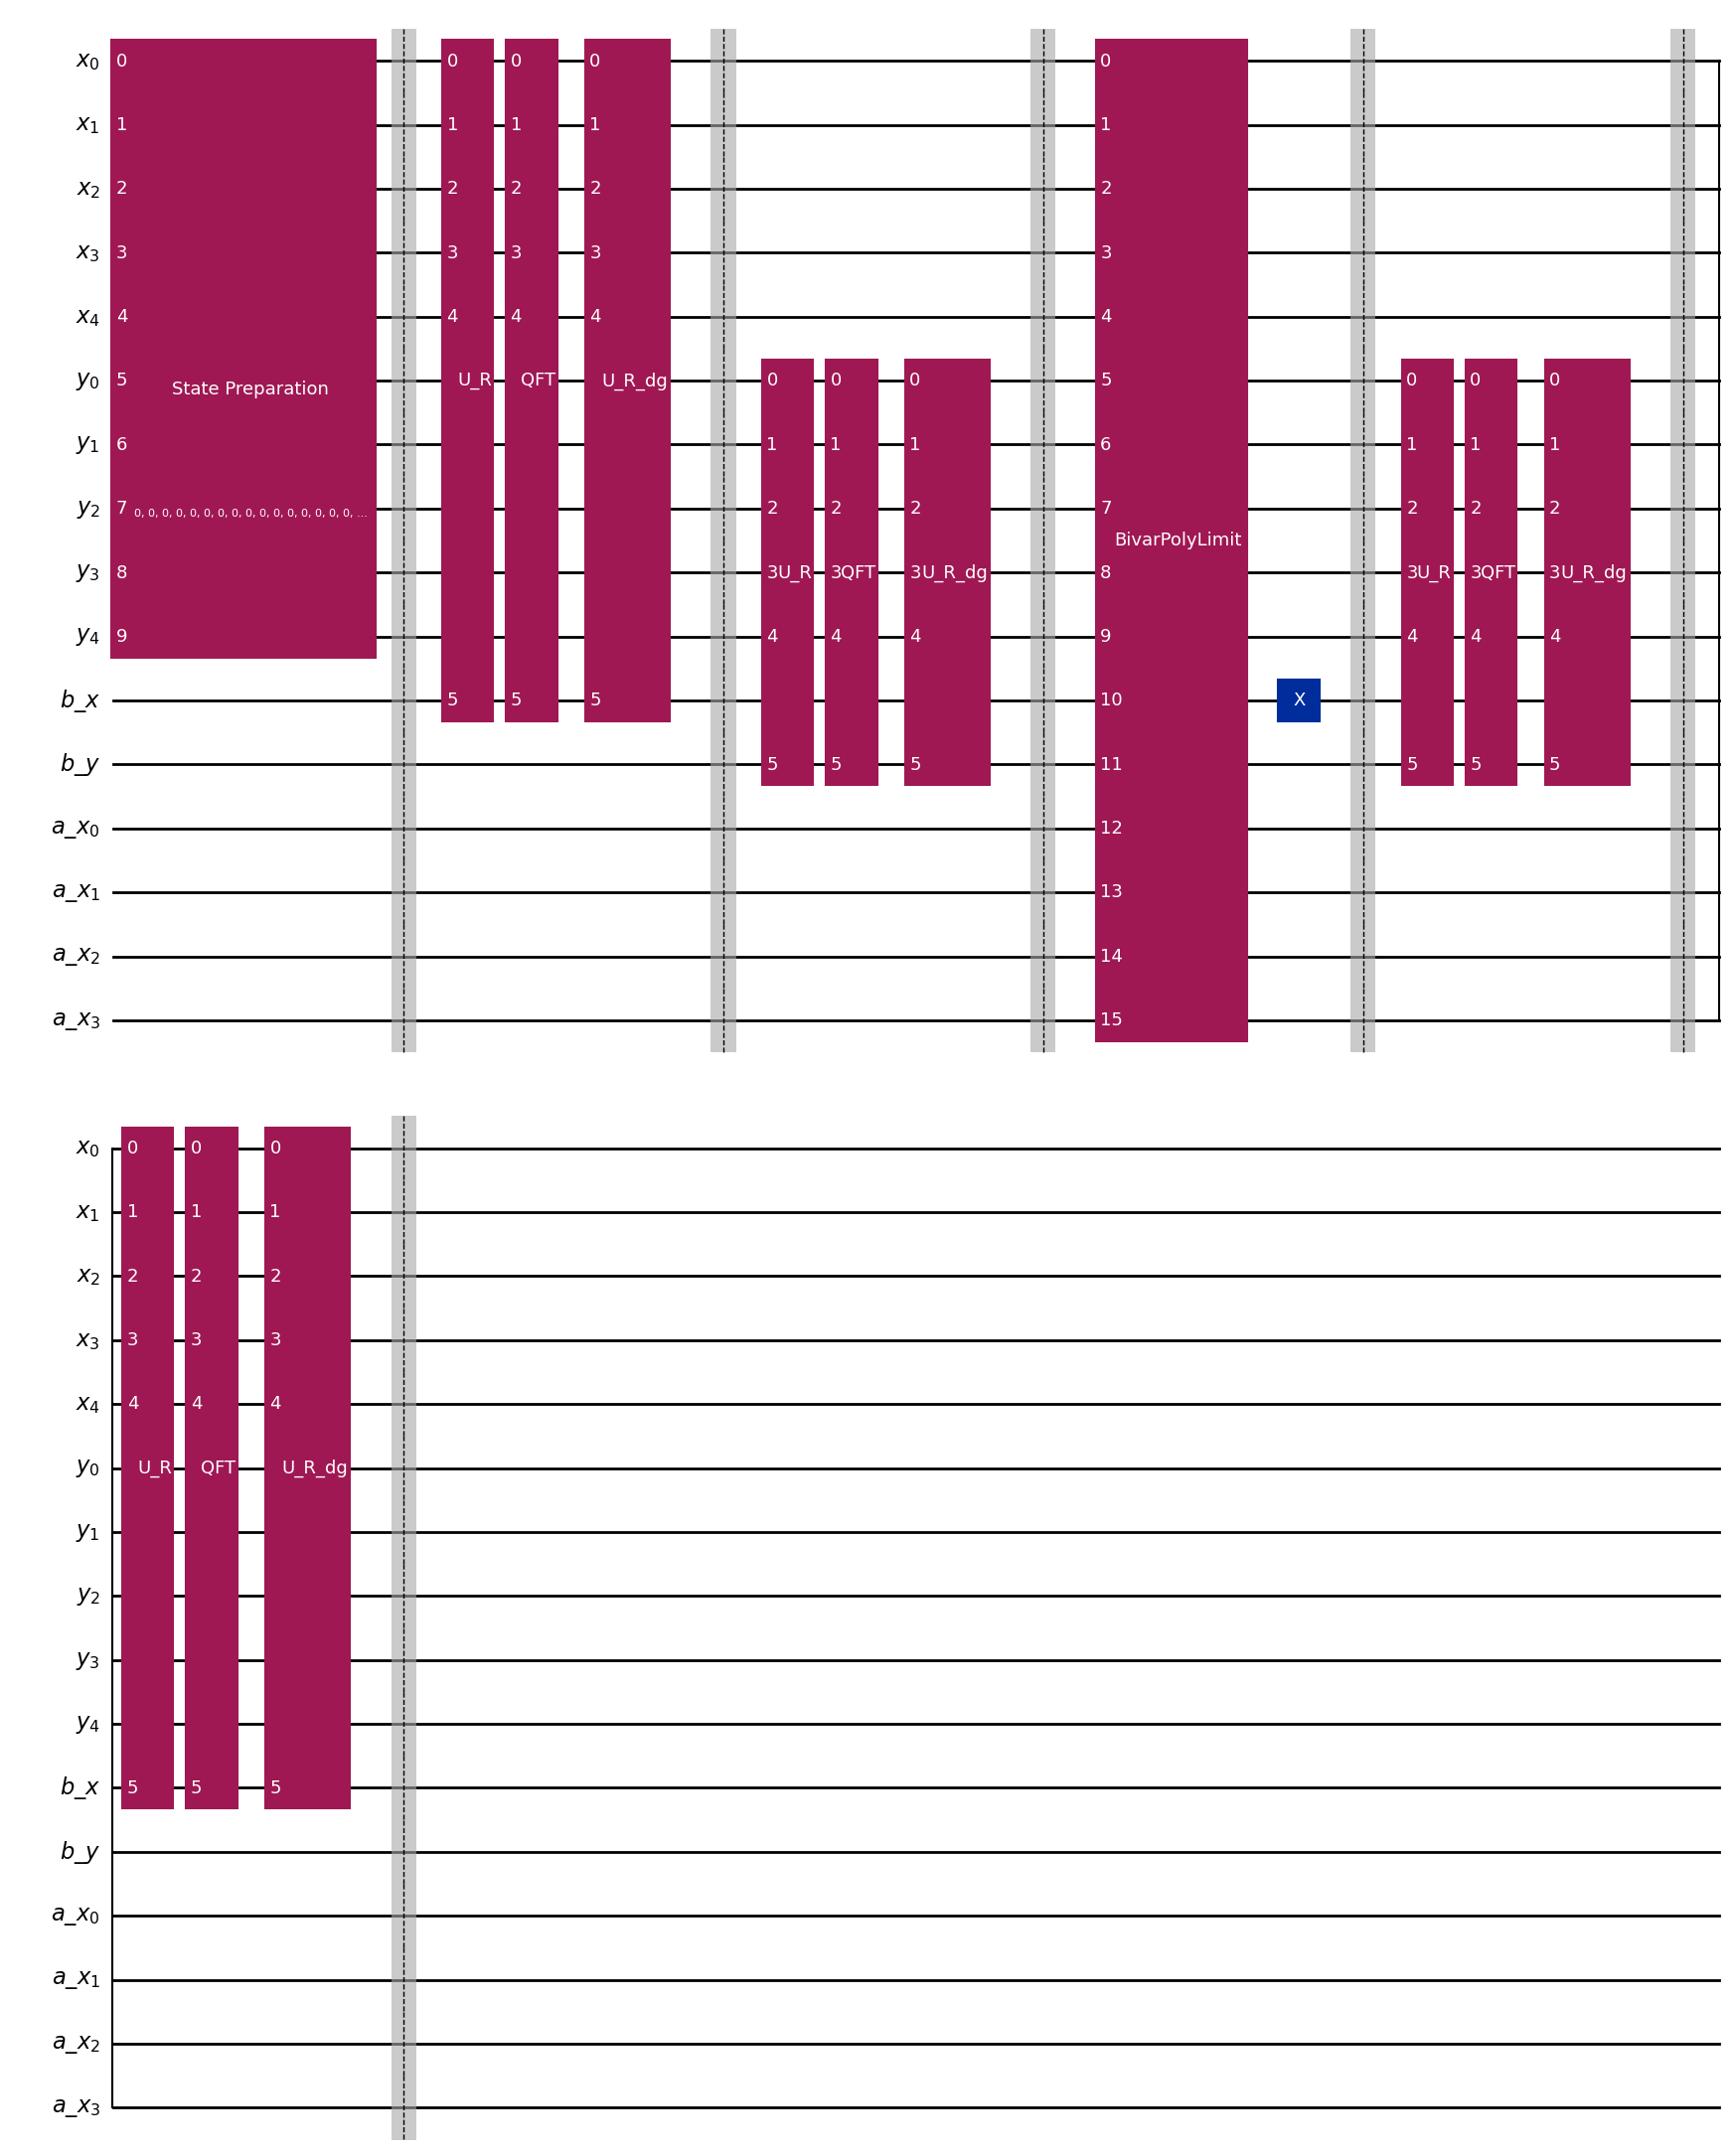

In [3]:
# number of qubits for discretisation
# x axis
nq_x = 5 # state qubits for x discretisation 
nb_x = 1
na_x = nq_x -1

# y axis
nq_y = nq_x # state qubits for y discretisation 
nb_y = 1
na_y = nq_y - 1

# for convenience
nq = nq_x + nq_y   # 2D state qubits
nb = nb_x + nb_y   # extension qubits 
na = na_x + na_y   # ancilla qubits

qcx = QuantumRegister(nq_x, 'x')
qbx = QuantumRegister(nb_x, 'b_x')
qax = QuantumRegister(na_x, 'a_x') 
qcy = QuantumRegister(nq_y, 'y')
qby = QuantumRegister(nb_y, 'b_y')
qay = QuantumRegister(na_y, 'a_y')
qc  = QuantumCircuit(qcx, qcy, qbx, qby, qax)

# domain definition in 1D
nd_1d = 2**(nq_x)         # number of elements in 1D
nd_2d = 2**(nq)           # number of elements in 2D
l  = 1.
x0 = 0.
x1 = x0 + l

# 2D grid generation
xi = np.linspace(x0, x1, nd_1d+1)
xi = xi[:nd_1d]
xv, yv = np.meshgrid(xi, xi)

fi = np.zeros(nd_2d)
for i in range(nd_1d):
    for j in range(nd_1d):
        fi[(nd_1d* i) + j] = forcing(xv[i,j], yv[i,j]) + d2g(xv[i,j], yv[i,j])

norm = np.linalg.norm(fi)

# state preparation
qc.append(StatePreparation(fi/norm), list(range(nq)))
qc.barrier()

# Reflection unitary U_R, use default method for forward shifting
qr = QuantumReflection(nq_x, 1)
qr_gate = qr.build()

# QFT
qft = QFT(num_qubits=nq_x+nb_x,inverse=False).to_gate()

# inverse of U_R
qref_inv = qr.inverse()
qr_inv_gate = qref_inv.to_gate(label="U_R_dg")

# Spectral transformation for x direction
qlist_spectral_x = list(range(nq_x)) + [nq]

qc.append(qr_gate, qlist_spectral_x)
qc.append(qft, qargs=qlist_spectral_x)
qc.append(qr_inv_gate, qlist_spectral_x)
qc.barrier()

# Spectral transformation for y direction
qlist_spectral_y = list(range(nq_x, nq)) + [nq + nb_x]

qc.append(qr_gate, qlist_spectral_y)
qc.append(qft, qargs=qlist_spectral_y)
qc.append(qr_inv_gate, qlist_spectral_y)
qc.barrier()

### Solve the Poisson equation in the Fourier space

# Multivariate polynomial encoder
eps                   = 1e-6
max_univariate_degree = 3
limit                 = 6 # Limit for the piecewise polynomial

coeffs_matrix = freqs_inv_coeffs(limit, 1, 1, max_univariate_degree)
qc.append(BivarPolyLimit(coeffs_matrix, limit, nq_x, max_univariate_degree, eps).build(), range(3*nq_x+1))
qc.x(nq)
qc.barrier()

# Spectral transformation for y direction
qc.append(qr_gate, qlist_spectral_y)
qc.append(qft, qargs=qlist_spectral_y)
qc.append(qr_inv_gate, qlist_spectral_y)
qc.barrier()

# Spectral transformation for x direction
qc.append(qr_gate, qlist_spectral_x)
qc.append(qft, qargs=qlist_spectral_x)
qc.append(qr_inv_gate, qlist_spectral_x)
qc.barrier()

qc.draw("mpl")


In [4]:
state = Statevector(qc)

fac    = (l/np.pi)**2
out    = np.real(norm*state.data)
result = fac*1/eps*out[0: nd_2d]

In [5]:
# analytical solution for the auxiliary field
def v(x,y):
    return np.sin(np.pi*x) * np.sin(4*np.pi*y) + np.sin(2*np.pi*x) * np.sin(3*np.pi*y)

analytic  = np.zeros((2**nq_x, 2**nq_x))
dir_fun   = np.zeros((2**nq_x, 2**nq_x))
force_fun = np.zeros((2**nq_x, 2**nq_x))

for i in range(2**nq_x):
    for j in range(2**nq_x):
        if i == 0 and j == 0:
            analytic[i,j] = 0.0
            dir_fun[i,j] = g(xv[i, j], yv[i,j])
            force_fun[i,j] = forcing(xv[i, j], yv[i,j])
        else:
            analytic[i,j] = v(xv[i, j], yv[i,j])
            dir_fun[i,j] = g(xv[i, j], yv[i,j])
            force_fun[i,j] = forcing(xv[i, j], yv[i,j])

# L2 error between quantum solution and analytical of the auxiliary field
errorL2 = 1/(nd_2d) * np.sqrt(((analytic - np.reshape(result, [nd_1d, nd_1d]))**2).sum())

print("L2 error: ", errorL2)

L2 error:  0.0014715262417173435


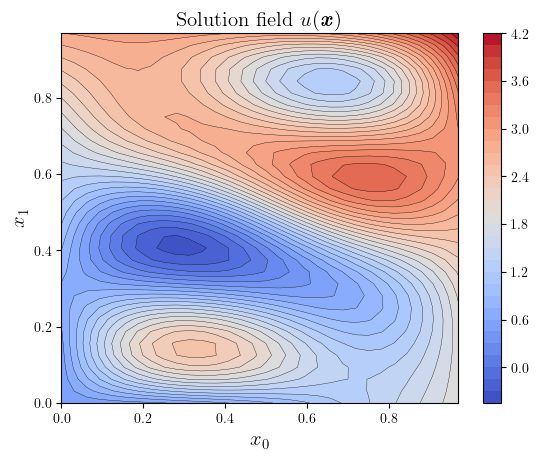

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})

plt.contour(xv, yv, result[0:nd_2d].reshape((nd_1d, nd_1d)) + dir_fun, levels=30, linestyles="solid", colors='k', linewidths=0.25)
plt.contourf(xv, yv, result[0:nd_2d].reshape((nd_1d, nd_1d)) + dir_fun, levels=30, cmap='coolwarm')

# ax.clabel(CS, fontsize=10)
plt.title('Solution field $u$(\\textit{\\textbf{x}})', fontsize=15)
plt.colorbar()

# set labels
plt.xlabel(r'$x_0$', fontsize=15)
plt.ylabel(r'$x_1$', fontsize=15)

# plt.savefig('soln-2d-poi-128-p3.pdf',bbox_inches = "tight")

In [7]:
from qiskit.compiler import transpile
transp = transpile(qc, basis_gates=['u3','cx'])
transp.count_ops()

OrderedDict([('u3', 27149), ('cx', 26223), ('barrier', 6)])

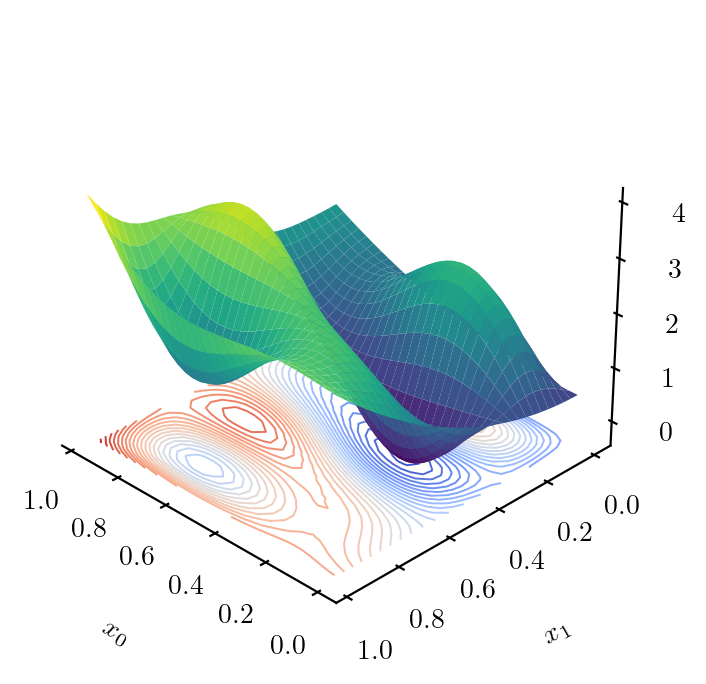

In [8]:
res = result[0:nd_2d].reshape((nd_1d, nd_1d)) + dir_fun

fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, res, cmap='viridis', edgecolor='none', antialiased=True)

ax.set_xlabel('$x_0$', labelpad=10)
ax.set_ylabel('$x_1$', labelpad=10)
ax.set_zlabel('$u(x_0, x_1)$', labelpad=10)

ax.contour(xv, yv, res, zdir='z', offset=np.min(res), cmap='coolwarm', levels=30, linewidths=0.7)

ax.grid(False)
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

ax.view_init(elev=30, azim=-225)
# plt.savefig("surface_u.pdf", bbox_inches='tight')